In [3]:
import os

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix

import tripletsiamese
import tensorsiamese
from tensorpair_test import SiameseTensorPairDataset
from offline_pair import OfflinePairDataset
from eval_metrics import evaluate, plot_roc

import config

/home/intern_aliff/die-link-siamese-classifier/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch.optim as optim

from tensorsiamese import SiameseNetwork

model = SiameseNetwork()
# For example, create an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2)  # Assume some parameters

# Get the name of the optimizer
optimizer_name = optimizer.__class__.__name__

print(optimizer_name)  # This will print 'Adam'
print(optimizer.param_groups)


Adam


In [4]:
def eval_bce(checkpoint_path, test_pairs, tensors):

    model = tensorsiamese.SiameseNetwork()
    model.to('cuda')

    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    print("epoch: ", checkpoint['epoch'])

    test_dataset = OfflinePairDataset(pair_dir=test_pairs, tensor_dir=tensors)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # Lists to store predictions and labels
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for (tensor1, tensor2), label in test_loader:
            tensor1, tensor2, label = map(lambda x: x.to('cuda'), [tensor1, tensor2, label])
            label = label.view(-1)

            prob = model(tensor1, tensor2).squeeze(1)

            # Store predictions and labels
            all_preds.extend((prob > 0.5).cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()

    cm = confusion_matrix(all_labels, all_preds)

    tn, fp, fn, tp = cm.ravel()
    
    # Calculate metrics
    accuracy = (all_labels == (all_preds > 0.5)).mean()
    precision = precision_score(all_labels, all_preds > 0.5)
    recall = recall_score(all_labels, all_preds > 0.5)
    f1 = f1_score(all_labels, all_preds > 0.5)
    auc = roc_auc_score(all_labels, all_preds)

    # Print metrics
    print(f'TP: {tp} | FP: {fp} | TN: {tn} | FN: {fn}')
    print(f'Accuracy: {accuracy:.3f}')
    print(f'Accuracy (from cm): {(tp+tn)/(tp+tn+fp+fn):.3f}')
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'F1 Score: {f1:.3f}')
    print(f'AUC: {auc:.3f}')

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


def eval_contrastive():
    
    pass

def eval_triplet(path):
    test_dir = config.obverse_test_dir
    test_csv = config.obverse_test_csv

    model = tripletsiamese.SiameseNetwork()
    model.to('cuda')

    checkpoint_path = path
    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    print("epoch: ", checkpoint['epoch'])

    test_dataset = SiameseTensorPairDataset(label_dir=test_csv, tensor_dir=test_dir)
    test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

    distances = []
    labels = []

    model.eval()
    with torch.no_grad():
        for (tensor1, tensor2), label in test_loader:
            tensor1, tensor2 = tensor1.to('cuda'), tensor2.to('cuda')

            emb1 = model.forward_once(tensor1)
            emb2 = model.forward_once(tensor2)

            # Compute Euclidean distance
            distance = torch.norm(emb1 - emb2, dim=1, p=2)  # p=2 denotes Euclidean norm
            distances.extend(distance.cpu().numpy())
            labels.extend(label.cpu().numpy())

    # Convert lists to numpy arrays for metric computation
    distances = np.array(distances)
    labels = np.array(labels)

    # Compute metrics
    thresholds = np.arange(0, 30, 0.01)
    precision_lst, recall_lst, f1_scores_lst = [], [], []
    for threshold in thresholds:
        predictions = (distances < threshold).astype(int)
        precision_lst.append(precision_score(labels, predictions))
        recall_lst.append(recall_score(labels, predictions))
        f1_scores_lst.append(f1_score(labels, predictions))

    # Find the optimal threshold (maximize F1 score for this example)
    optimal_idx = np.argmax(f1_scores_lst)
    optimal_threshold = thresholds[optimal_idx]

    # Compute metrics at optimal threshold
    optimal_predictions = (distances < optimal_threshold).astype(int)
    optimal_precision = precision_score(labels, optimal_predictions)
    optimal_recall = recall_score(labels, optimal_predictions)
    optimal_f1 = f1_score(labels, optimal_predictions)

    # Compute AUC
    auc_score = roc_auc_score(labels, distances)  # Note: ensure the scoring is consistent with distance measure

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(labels, distances)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label='Optimal Threshold')  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Print metrics
    print(f'Optimal threshold: {optimal_threshold}')
    print(f'Precision at optimal threshold: {optimal_precision}')
    print(f'Recall at optimal threshold: {optimal_recall}')
    print(f'F1 Score at optimal threshold: {optimal_f1}')
    print(f'AUC: {auc_score}')

Combined model on combined test set
epoch:  37


TP: 5893 | FP: 33 | TN: 5877 | FN: 17
Accuracy: 0.996
Accuracy (from cm): 0.996
Precision: 0.994
Recall: 0.997
F1 Score: 0.996
AUC: 0.996


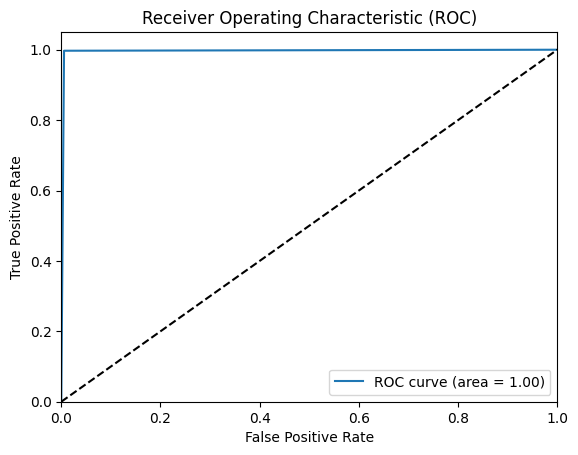

Combined model on obverse test set
epoch:  37
TP: 1024 | FP: 102 | TN: 975 | FN: 53
Accuracy: 0.928
Accuracy (from cm): 0.928
Precision: 0.909
Recall: 0.951
F1 Score: 0.930
AUC: 0.928


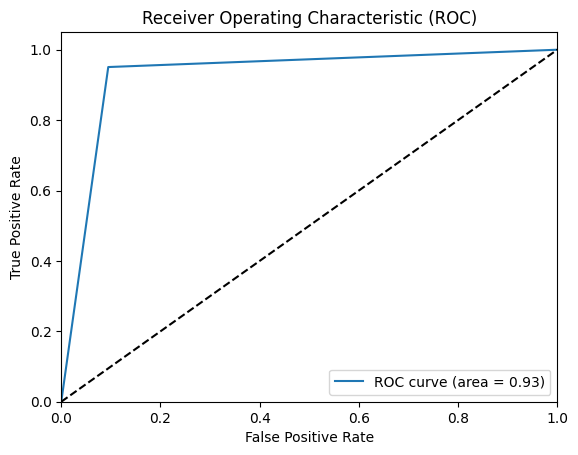

Combined model on reverse test set
epoch:  37
TP: 175 | FP: 22 | TN: 169 | FN: 16
Accuracy: 0.901
Accuracy (from cm): 0.901
Precision: 0.888
Recall: 0.916
F1 Score: 0.902
AUC: 0.901


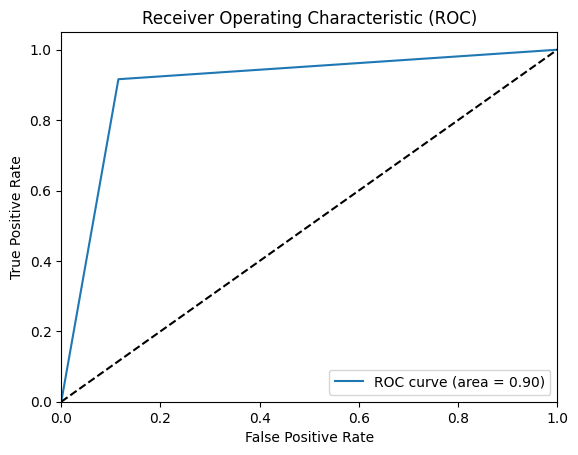

In [7]:
obverse_model = 'runs/bce-obverse/best.pt'
reverse_model = 'runs/bce-reverse/best.pt'
combine_model = 'runs/bce-combine/best.pt'

combine_pairs = config.combined_test
obverse_pairs = config.obverse_test
reverse_pairs = config.reverse_test

obverse_tensors = config.obverse_tensors
reverse_tensors = config.reverse_tensors
combine_tensors = config.combined_tensors

print("Combined model on combined test set")
eval_bce(combine_model, combine_pairs, combine_tensors)

print("Combined model on obverse test set")
eval_bce(combine_model, obverse_pairs, obverse_tensors)

print("Combined model on reverse test set")
eval_bce(combine_model, reverse_pairs, reverse_tensors)
# print("Obverse model on obverse test set")
# eval_bce(obverse_model, obverse_pairs, obverse_tensors)
# print("Reverse model on reverse test set")
# eval_bce(reverse_model, reverse_pairs, reverse_tensors)

# print("Obverse model on reverse test set")
# eval_bce(obverse_model, reverse_pairs, reverse_tensors)
# print("Reverse model on obverse test set")
# eval_bce(reverse_model, obverse_pairs, obverse_tensors)
